In [53]:
library(MASS)
library(vegan)
library(ggplot2)
library(plotrix)
library("plot3D")
library (Heatplus)
library(reshape)
library(dplyr)
library(RColorBrewer)
library(gplots)
library(readxl)
library(patternplot)
library(agricolae)
library("phyloseq")
library("ggplot2")      # graphics
library("tibble")
library(factoextra)
library(reticulate)
library(rstatix)
library(ggrepel)

In [54]:
otu<-as.data.frame(read.table("otu.txt",header=T, row.names=1,sep="\t"))
map<-read.table("map.txt",header=T, row.names=1,sep="\t")
otu1<-t(otu[,1:(dim(otu)[2]-4)])
otu1<- decostand((otu1), "total")
sp=t(otu[,1:(dim(otu)[2]-4)])

In [55]:
rownames(map)
rownames(otu1)
colnames(otu)

[1] "SW_030" "SW_060" "SW_090" "SW_360" "CA_030" "CA_060" "CA_090" "CA_360"
 [9] "PP_030" "PP_060" "PP_090" "PP_360" "DN_030" "DN_060" "DN_090" "DN_360"

[1] "SW_30"   "SW_60"   "SW_90"   "SW_360"  "CA_30"   "CA_60"   "CA_90"  
 [8] "CA_360"  "PP_30"   "PP_60"   "PP_90"   "PP_360"  "DN_30"   "DN_60"  
[15] "DN_90"   "DND_360"

[1] "SW_30"    "SW_60"    "SW_90"    "SW_360"   "CA_30"    "CA_60"   
 [7] "CA_90"    "CA_360"   "PP_30"    "PP_60"    "PP_90"    "PP_360"  
[13] "DN_30"    "DN_60"    "DN_90"    "DND_360"  "Kingdome" "Phylum"  
[19] "Class"    "Order"

In [4]:
adonis(vegdist((sp),method="bray")~ map$AS/map$day+map$day, permuitation=9999)


Call:
adonis(formula = vegdist((sp), method = "bray") ~ map$AS/map$day +      map$day, permuitation = 9999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
map$AS          3    0.4560 0.15202  0.6855 0.11877  0.754    
map$day         1    1.2287 1.22870  5.5411 0.31999  0.001 ***
map$AS:map$day  3    0.3811 0.12704  0.5729 0.09925  0.934    
Residuals       8    1.7739 0.22174         0.46199           
Total          15    3.8398                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

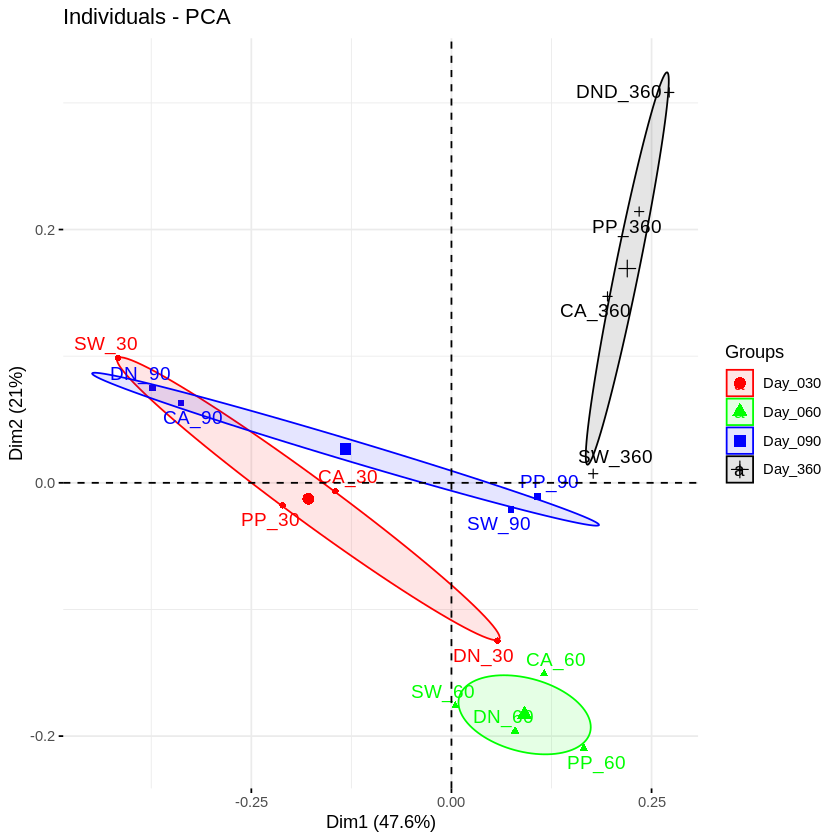

In [5]:
data.scores <- prcomp(otu1, scale = FALSE)
data.scores$day = map$CDay
data.scores$AS = map$AS
# pdf("pca.pdf")
fviz_pca_ind(data.scores,
             col.ind = map$CDay, # color by groups
             palette = c("red",  "green","blue",  "black"),
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Groups",
             repel = TRUE
             )
# dev.off()

In [6]:
env.par<- c("day","AS","DOC","TP","PO4","TDN","NH4","NO3")
#scale parameters
metadata.scaled <- data.frame(map) %>% 
mutate_at(all_of(env.par),as.numeric) #%>%
#   mutate_if(is.numeric, scale_par)
envpar_corr <- metadata.scaled %>% 
  select(all_of(env.par))%>% 
  cor_mat(method = "pearson")
# envpar_corr


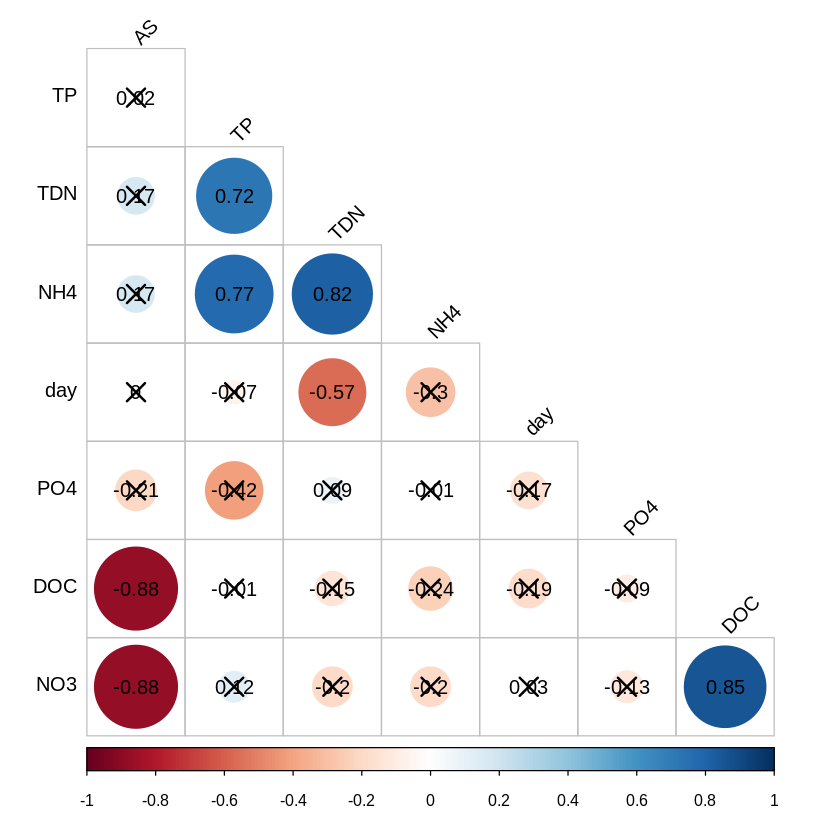

In [7]:
# pdf("pearson.pdf")
envpar_corr.pvalues<- envpar_corr %>% cor_get_pval()
# envpar_corr.pvalues
envpar_corr %>%
  cor_reorder() %>%
  pull_lower_triangle() %>%
  cor_plot(label =TRUE)
# dev.off()

In [8]:
otu_rda <- rda(otu1 ~ ., data = map) # model including all variables 
vif.cca(otu_rda)
R2.pig<-RsquareAdj(otu_rda)
P2.pig<-anova(otu_rda)
anova(otu_rda,by="terms",permutation=9999)
# anova(otu_rda,by="axis")

CDayDay_060 CDayDay_090 CDayDay_360         day        ASDN        ASPP 
   1.697107    2.819718   13.267428          NA   85.381088  348.815664 
       ASSW         DOC          TP         PO4         TDN         NH4 
 167.711108   54.763326  743.128311   38.148495   71.673202   19.995108 
        NO3 
  48.253981

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
CDay,3,0.049184115,3.9018000,0.009
AS,3,0.012401975,0.9838548,0.492
DOC,1,0.007890386,1.8778446,0.160
TP,1,0.004889729,1.1637138,0.333
PO4,1,0.006653914,1.5835748,0.242
TDN,1,0.003962983,0.9431562,0.459
NH4,1,0.003121739,0.7429473,0.567
NO3,1,0.005428124,1.2918473,0.277
Residual,3,0.012605494,NA,NA


Warning message:
“ggrepel: 178 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


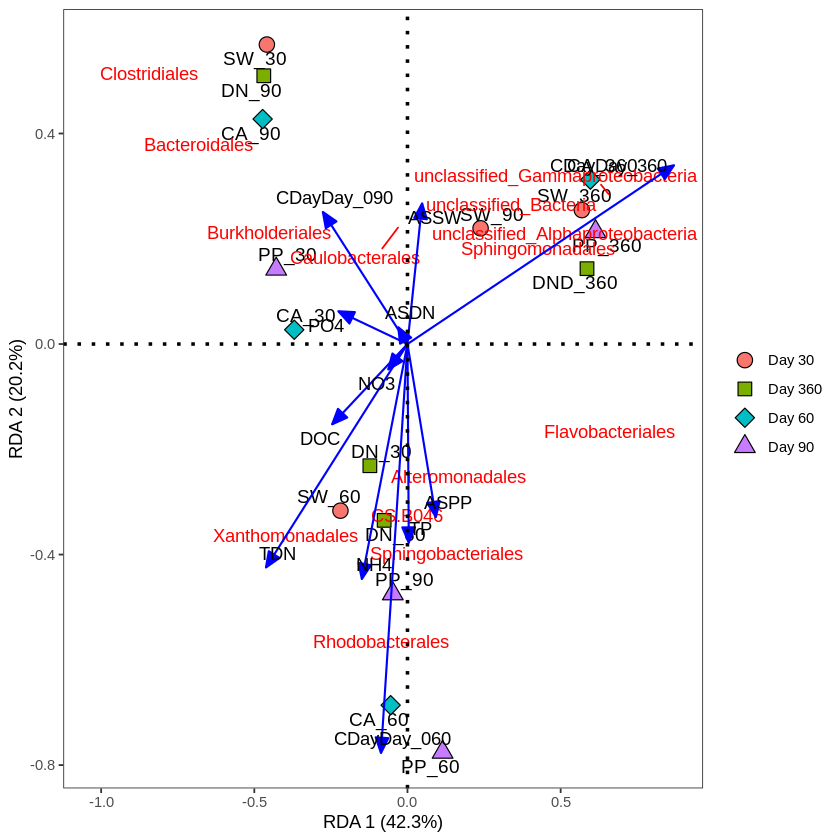

In [19]:
fc=map
sp=t(otu[,1:(dim(otu)[2]-4)])
colnames(sp)<-otu$Order
spp=decostand(sp,method = "hellinger")#Convert response variables
    
uu=rda(spp~.,fc)#RDA Analysis
ii=summary(uu)  #View analysis results
sp=as.data.frame(ii$species[,1:2])*2#Depending on the drawing result, the drawing data can be enlarged or reduced to a certain extent, as follows
st=as.data.frame(ii$sites[,1:2])
yz=as.data.frame(ii$biplot[,1:2])
grp=as.data.frame(c(rep("Day 30",4),rep("Day 60",4),rep("Day 90",4),rep("Day 360",4)))#Grouping by Square Type
colnames(grp)="group"
# pdf("rda.pdf")
ggplot() +
   geom_text_repel(data = st,aes(RDA1,RDA2,label=row.names(st)),size=4)+#Show a Square
   geom_point(data = st,aes(RDA1,RDA2,shape=grp$group,fill=grp$group),size=4)+
   scale_shape_manual(values = c(21:25))+
#     geom_segment(data = sp,aes(x = 0, y = 0, xend = RDA1, yend = RDA2), 
     #            arrow = arrow(angle=22.5,length = unit(0.35,"cm"),
      #                         type = "closed"),linetype=1, size=0.6,colour = "red")+
        geom_text_repel(data = sp,aes(RDA1,RDA2,label=row.names(sp)),color="red")+
   geom_segment(data = yz,aes(x = 0, y = 0, xend = RDA1, yend = RDA2), 
                arrow = arrow(angle=22.5,length = unit(0.35,"cm"),
                              type = "closed"),linetype=1, size=0.6,colour = "blue")+
   geom_text_repel(data = yz,aes(RDA1,RDA2,label=row.names(yz)))+
         labs(x=paste("RDA 1 (", format(100 *ii$cont[[1]][2,1], digits=4), "%)", sep=""),
              y=paste("RDA 2 (", format(100 *ii$cont[[1]][2,2], digits=4), "%)", sep=""))+
          geom_hline(yintercept=0,linetype=3,size=1) + 
            geom_vline(xintercept=0,linetype=3,size=1)+
   guides(shape=guide_legend(title=NULL,color="black"),
          fill=guide_legend(title=NULL))+
              theme_bw()+theme(panel.grid=element_blank())
# dev.off()


In [15]:
Acidobacteriota<-colorRampPalette(c("lightgray","lightgray"))
Actinobacteria<-colorRampPalette(c("yellow2","yellow2")) #exp3_not_UV
Alteromonadales<-colorRampPalette(c("pink4","pink4")) 
Bacteroidetes<-colorRampPalette(c("orange2","orange2"))
Cyanobacteria<-colorRampPalette(c("green2","green2"))
Delftia<-colorRampPalette(c("white","white"))

Dependentiae<-colorRampPalette(c("darkmagenta","darkmagenta"))#exp4_not_UV
Desulfobacterota<-colorRampPalette(c("yellow4","yellow4"))#exp4_UV and not_UV
Campilobacterota<-colorRampPalette(c("green4","green4"))#exp3_not_UV
Firmicutes<-colorRampPalette(c("pink1","pink1"))
Fusobacteriota<-colorRampPalette(c("magenta","magenta"))#exp4_not_UV

Gemmatimonadota<-colorRampPalette(c("darkgoldenrod1","darkgoldenrod4"))
parahaemolyticus<-colorRampPalette(c("lightgray","lightgray"))
Photobacterium<-colorRampPalette(c("lightblue","lightblue"))
Planctomycetes<-colorRampPalette(c("green3","green3"))

Myxococcota<-colorRampPalette(c("magenta","darkmagenta"))#exp3_not_UV
Chloroflexi<-colorRampPalette(c("black","black"))
OD1<-colorRampPalette(c("green1","green1"))
unclassified<-colorRampPalette(c("darkgray","darkgray"))#exp3_UV
Proteobacteria<-colorRampPalette(c("blue1","blue4"))
Ralstonia<-colorRampPalette(c("brown1","brown1"))
Synergistetes<-colorRampPalette(c("cyan1","cyan1"))
# Streptococcus_iniae<-colorRampPalette(c("white","white"))
Verrucomicrobia<-colorRampPalette(c("cyan4","cyan4"))
Vibrio<-colorRampPalette(c("red2","red2"))
Vibrionaceae<-colorRampPalette(c("red4","red4"))

[1] "SW_30"   "SW_60"   "SW_90"   "SW_360"  "CA_30"   "CA_60"   "CA_90"  
 [8] "CA_360"  "PP_30"   "PP_60"   "PP_90"   "PP_360"  "DN_30"   "DN_60"  
[15] "DN_90"   "DND_360"

[1] "   SW_030" "   SW_060" "   SW_090" "   SW_360" "   CA_030" "   CA_060"
 [7] "   CA_090" "   CA_360" "   PP_030" "   PP_060" "   PP_090" "   PP_360"
[13] "   DN_030" "   DN_060" "   DN_090" "   DN_360"

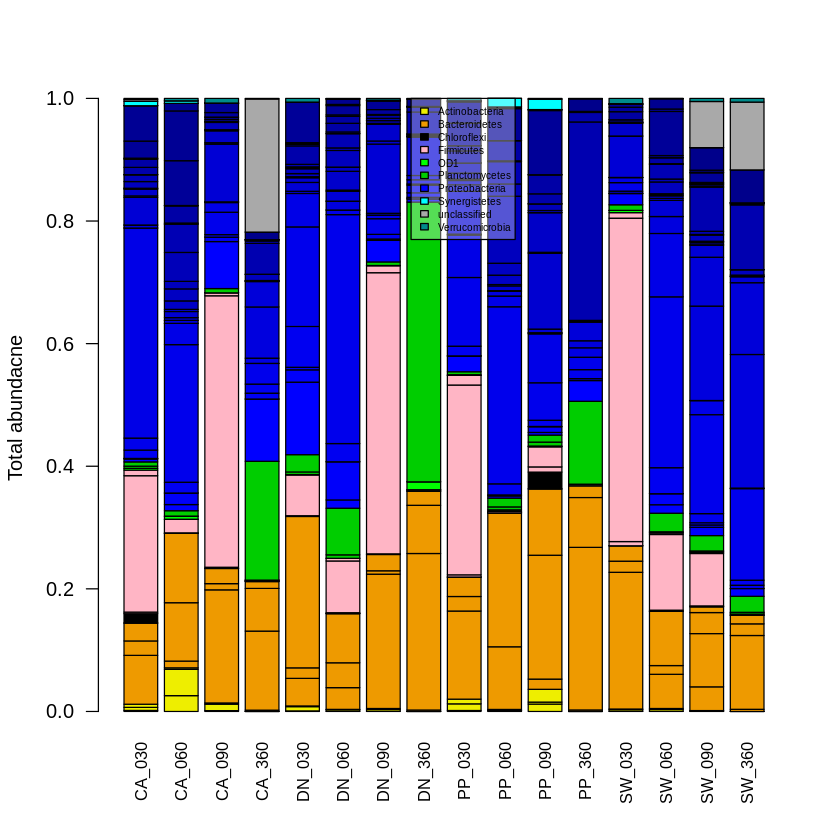

In [56]:
sp=(otu[,1:(dim(otu)[2]-4)])
x<-as.data.frame(t(decostand(t(sp),method="total")))
Phylum<-otu$Phylum
p<-cbind(x,Phylum)

all_n<-p[rowSums(p[,1:(dim(p)[2]-1)])>=0.02500, ,drop=FALSE]

all_n<-all_n[order(all_n$Phylum),]
write.table(all_n,"all_n",sep="\t",quote=FALSE)
all_n<-read.table("all_n",header=T,row.names=1,sep="\t")


all_n<-all_n[order(all_n$Phylum),]
c<-table(all_n$Phylum)
c<-as.matrix(c)

write.table(c,"phylum.table",sep=" ", quote=FALSE, col.names=F,row.names=T)
py_run_file("AshrafColoreR.py")
source("Phylum_Color.r")
lm<-c
lm[lm>0]<-1
l<-rownames(lm)[lm[,1]>0]
write.table(lm,"legend.table",sep=" ", quote=FALSE, col.names=F,row.names=T)
py_run_file("legendColoreR.py")
source("legend_Color.r")

y<-all_n[,1:(dim(all_n)[2]-1)]
y1<-t(y)
rownames(y1)
b<-paste(map$Source,map$Time,map$Tank,rownames(map))
b
rownames(y1)<-b
write.table(y1,"forward_y1",sep="\t",quote=F)


y1<-read.table("forward_y1",header=T,row.names=1,sep="\t")
y1<-decostand(y1,method="total")
y1 <- y1[ order(row.names(y1)), ]

# pdf("bar_phylum.pdf")
barplot(t(y1),col=colors(sum(c[,1])),las=2,ylab="Total abundacne",lwd=1,cex.names=0.82)
legend(1,l,bg="#ffffff55",fill=colorslm(sum(lm[,1])),xjust=-2.5,xpd=T,cex=0.5)
# dev.off()

[1] "SW_30"   "SW_60"   "SW_90"   "SW_360"  "CA_30"   "CA_60"   "CA_90"  
 [8] "CA_360"  "PP_30"   "PP_60"   "PP_90"   "PP_360"  "DN_30"   "DN_60"  
[15] "DN_90"   "DND_360"

[1] "   SW_030" "   SW_060" "   SW_090" "   SW_360" "   CA_030" "   CA_060"
 [7] "   CA_090" "   CA_360" "   PP_030" "   PP_060" "   PP_090" "   PP_360"
[13] "   DN_030" "   DN_060" "   DN_090" "   DN_360"

Warning message in breakColors(breaks, col):
“more colors than classes: ignoring 8 last colors”


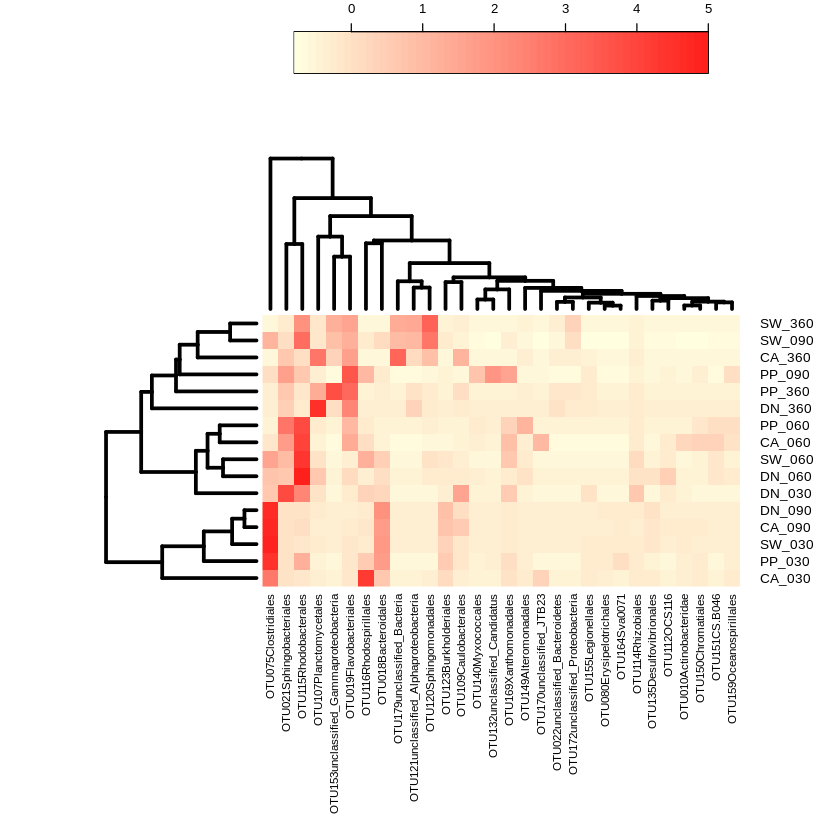

In [89]:
sp=(otu[,1:(dim(otu)[2]-4)])
rownames(sp)<-paste0(rownames(otu),otu$Order)
x<-as.data.frame(t(decostand(t(sp),method="total")))
Phylum<-otu$Phylum
p<-cbind(x,Phylum)

all_n<-p[rowSums(p[,1:(dim(p)[2]-1)])>=0.05, ,drop=FALSE]

all_n<-all_n[order(all_n$Phylum),]
write.table(all_n,"all_n",sep="\t",quote=FALSE)
all_n<-read.table("all_n",header=T,row.names=1,sep="\t")


all_n<-all_n[order(all_n$Phylum),]
c<-table(all_n$Phylum)
c<-as.matrix(c)

write.table(c,"phylum.table",sep=" ", quote=FALSE, col.names=F,row.names=T)
py_run_file("AshrafColoreR.py")
source("Phylum_Color.r")
lm<-c
lm[lm>0]<-1
l<-rownames(lm)[lm[,1]>0]
write.table(lm,"legend.table",sep=" ", quote=FALSE, col.names=F,row.names=T)
py_run_file("legendColoreR.py")
source("legend_Color.r")

y<-all_n[,1:(dim(all_n)[2]-1)]
y1<-t(y)
rownames(y1)
b<-paste(map$Source,map$Time,map$Tank,rownames(map))
b
rownames(y1)<-b
write.table(y1,"forward_y1",sep="\t",quote=F)


y1<-read.table("forward_y1",header=T,row.names=1,sep="\t")
y1<-decostand(y1,method="total")
y1 <- y1[ order(row.names(y1)), ]
# pdf("heatmap.pdf")
plot(annHeatmap2(as.matrix(y1),col = colorRampPalette(c("lightyellow", "red"), space = "rgb")(66), breaks = 65,legend=3,labels=list(Col=list(nrow=16))))
# dev.off()

Warning message in breakColors(breaks, col):
“more colors than classes: ignoring 13 last colors”


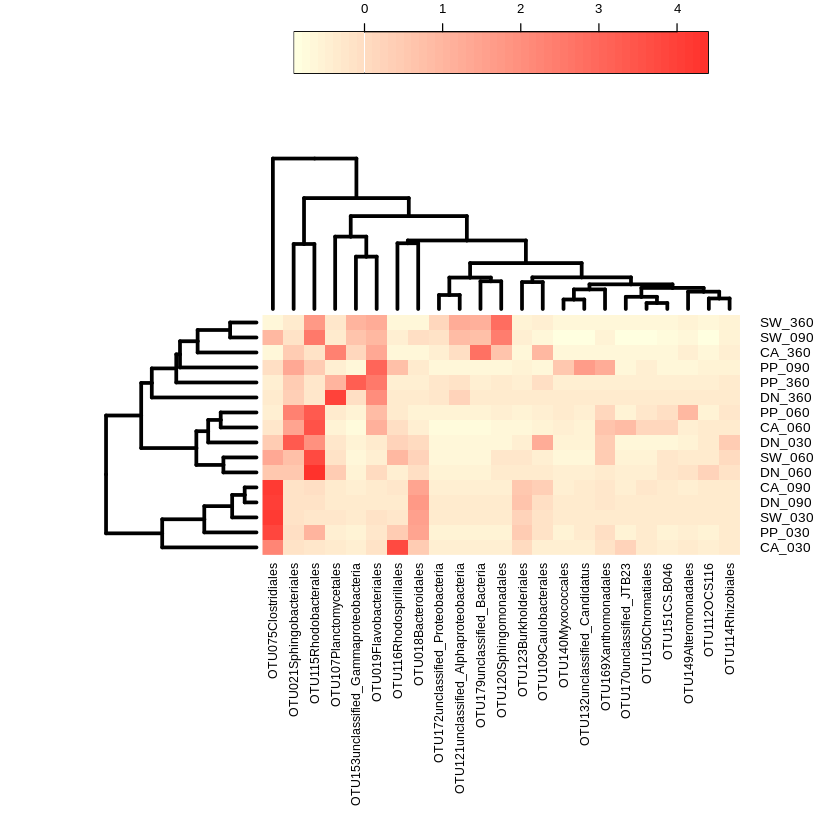

In [87]:
maxab <- apply(y1, 2, max)
n1 <- names(which(maxab < 0.05))
data.prop.1 <- y1[, -which(names(y1) %in% n1)]
data.dist <- vegdist(y1, method = "bray")
row.clus <- hclust(data.dist, "complete")
data.dist.g <- vegdist(t(data.prop.1), method = "bray")
col.clus <- hclust(data.dist.g, "complete")
scaleyellowred <- colorRampPalette(c("lightyellow", "red"), space = "rgb")(100)
# pdf("/home/ashraf/Documents/Acacia/pear/bowtie2/mothurQC/splited_16S/F649_R889/tortilis_23_map_Month_1.pdf")
plot(annHeatmap2(as.matrix(data.prop.1),col = colorRampPalette(c("lightyellow", "red"), space = "rgb")(66), breaks = 65,legend=3,labels=list(Col=list(nrow=18))))
# dev.off()